# Creation of a Full Recommender System through Contextual Decoupling

## Introduction

Throughout this course, we have progressed with more and more advanced models for Recommender Systems. In this final step, we propose a complete Recommender System, that takes advantage of an large and vast dataset in order conduct an in depth investigation into the ideas that we have explored over the course of the last 7 weeks. Unlike the other projects that focused specifically on implement small recommender systems, our project here focuses on optimization of several ideas in order to implement a complete Recommender system, that takes time costs, and processing speed into consideration. Again our data is targeted torwards the movie genre (as again the dataset is readily available), but here we propose a more broad scope of techniques to minimize processing speed and optimize accuracy. As we move forward with technology, our amount of data continues to exponential grow, and the best way to process this vast source of data. Our target audience here would be any data host, with a continually growing data source, as we would like to be able to create a continually adaptable recommender system that does not require an epic amount of processing time. The way we propose to do this is to utilize the idea of Decoupling 

## Data Source and Cleaning

For this project we will continue to use the MovieLens data source. However, in previous project we utilized that smaller of the dataset, as we are scaling this to a large source, we will move to the 1 million dataset. The dataset utilized in this project was slightly different, and required a significant amount of cleaning (for whatever reason they decided to save the data in a completely different format for the 1 million dataset). A complete copy of the code for data_extraction is given in the attached Data Extraction.py file in the github page. The datasets we extracted are given below: 
* Movie Content
    * Total 3706 Movies Titles with 18 features
    * Each column represents a genre:"Action","Adventure","Animation","Children's","Comedy","Crime", "Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"
    * A specific movie can have more than 1 genre (the most any one movie has is 6)
* User Content 
    * Total 6040 users with 29 features
    * Features in order are Column 1 = Gender, Column 2-21 = specific job, and column 22-29 an age Range given as follows:
        *  1:  "Under 18"
        * 18:  "18-24"
        * 25:  "25-34"
        * 35:  "35-44"
        * 45:  "45-49"
        * 50:  "50-55"
        * 56:  "56+"   
The source code for data extraction is given below: (please note this is only the data)

In [124]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Data file containing ratings data
ratings = pd.read_csv("data/ratings.dat", delimiter ="::", header=None, 
                      names=["user_id", "movies_id","rating","timestamp"],engine='python')

#Data containing movie data
movies = pd.read_csv("data/movies.dat", delimiter ="::", header=None, 
                      names=["movies_id","title","genre"], engine='python')

#Data containing User Data 
users = pd.read_csv("data/users.dat", delimiter ="::", header=None, 
                      names=["user_id", "gender","age","occupation","zip"], engine='python')

#Extracting Data Ratings data:
ratings = ratings.drop(["timestamp"], 1)
ratings_int = ratings.pivot(index = "user_id", columns = "movies_id", values = "rating")

#Extracting Movies Data
movie_titles = movies 

genres = ["Action","Adventure","Animation","Children's","Comedy","Crime",
          "Documentary","Drama","Fantasy","Film-Noir","Horror","Musical",
          "Mystery","Romance","Sci-Fi","Thriller","War","Western"]

movies = movies.drop(["title"],1)
movies = movies.set_index("movies_id")
movies = movies['genre'].str.split("|", expand = True)

dummies1 = pd.get_dummies(movies[0], prefix='genre', prefix_sep='_')
col_names_dummies = dummies1.columns.values

dummies2 = pd.get_dummies(movies[1], prefix='genre', prefix_sep='_')
col_names_dummies = dummies1.columns.values

dummies3 = pd.get_dummies(movies[2], prefix='genre', prefix_sep='_')
col_names_dummies = dummies1.columns.values

dummies4 = pd.get_dummies(movies[3], prefix='genre', prefix_sep='_')
col_names_dummies = dummies1.columns.values

dummies5 = pd.get_dummies(movies[4], prefix='genre', prefix_sep='_')
col_names_dummies = dummies1.columns.values

dummies6 = pd.get_dummies(movies[5], prefix='genre', prefix_sep='_')
col_names_dummies = dummies1.columns.values

names = dummies1.columns.values

dummies = dummies1.replace(0,np.nan)
dummies2 = dummies2.replace(0,np.nan)
dummies3 = dummies3.replace(0,np.nan)
dummies4 = dummies4.replace(0,np.nan)
dummies5 = dummies5.replace(0,np.nan)
dummies = dummies.combine_first(dummies2)
dummies = dummies.combine_first(dummies3)
dummies = dummies.combine_first(dummies4)
dummies = dummies.combine_first(dummies5)

dummies = dummies.fillna(0)
movies = dummies
name = list(ratings_int.columns.values)
movies = movies.T
movies = movies[name]
movies = movies.T

#Extracting User Data
users = users.set_index("user_id")
#Creating Dummy col for jobs
dummies = pd.get_dummies(users['occupation'], prefix='job', prefix_sep='_')
col_names_dummies = dummies.columns.values

for i,value in enumerate(col_names_dummies):
    users[value] = dummies.iloc[:,i]

#Creating Dummy col for age
dummies = pd.get_dummies(users['age'], prefix='age', prefix_sep='_')
col_names_dummies = dummies.columns.values

for i,value in enumerate(col_names_dummies):
    users[value] = dummies.iloc[:,i]

map_gender = {"M":0,"F":1}
users = users.replace({"gender": map_gender})
users = users.drop(["age","occupation","zip"], 1)

# Borrowed some code here from Padebetttu et. al. -DATA643- Project 2
ratings_mean = ratings_int.apply(lambda x: x.fillna(x.mean(skipna = True)),axis=1)
ratings = ratings_mean.apply(lambda x: x-x.mean(), axis = 1).round(5)

## Methodology

Like Project 4, the same Data Acquistion and Normalization step will be done with our final. The first two steps are a repeat of the methodology from Project 4's Proposal.
* Data Acquistion and Normaliation
    * The first step of this process will be to process the data. For the data will be organized into 3 matrices, a User-content matrix, an Item-Content Matrix and a User-Item Rating matrix. For the movie and User content matrices, each row will represent an movie or user, respectively, while the columns will represent a specific aspect of the movie or user. For istances, all the movie break downs will be either 0 or 1, indicating if it belongs to a specific genre (19 in total). For the users, each column will represnt a specific age range the belong to, their gender, and their occupation. 
* Matrix Factorization 
    * For our process here we will utilized standard Singular Value Decomposition for the most part. However, an attempt will be made at utilizing Weighted ALS for a smaller subset. The idea here is that we can "fill" in the larger sparse data with a subset chosen based on age. This in theory would weight the factorization, and skew it heavily on the side of the age range picked (the thought here being that you would complete each ALS factorization for all the age ranges). As SVD tends to produce values that "overfit" producing values that meet the factorization, but do are not viable, the other factorization process are preferred.    
    * The idea her would be to create multiple iterations, "randomly" splitting the dataset as a whole, completing the subset matrices, and then combining the subsets into the whole. After each iteration, we would then calculate the RMSE, and then repeat the process. Theoretically, after each step, the RMSE would decrease (if it is indeed the case)[5]. (I am attempting to obtain the publication for Barjasteh et. al [5]. At the moment I'd have to purchase it, but I signed up for free version through requests). From the video, there was some doubts on whether or not these results were accurate. Though they utilize a much more complex system, then the one I propose, if their stipulation that one can complete thest small subsets (that meet certain rank requirements) at random and produce accurate results. For our purposes here, due to the inability to get the AWS Sparks running, we are changing the "Randomly" selected datasets, and replacing them with specific contextual based subsets. First, each age range was extracted, with the understanding that people of different age groups will rate differently, based on personal preference. Using SVD, each of these individual subsets were then factored down and reproduced using a smaller feature set (k= 50 this number was chosen based on previous projects). Furthermore, we took several genre examples as well. I chose the 7 genres that I felt most distinctly represented the group as a whole: action, children's, comedy, drama, horror, romance, and sci-fi.One cause for concern however, was that each 

## Experimentation

Taking the above data, and using a modified SVD code, we created several subsets based on age and genre as described above. 

In [125]:
#Context Break-down to "Decouple" Data for age
def subset_users(ratings,users,col):
    Rating= ratings.loc[list(users[users[col] >0].T.columns.values)]
    return Rating

Ratings_1 = subset_users(ratings,users,'age_1')
Ratings_2 = subset_users(ratings,users,'age_18')
Ratings_3 = subset_users(ratings,users,'age_25')
Ratings_4 = subset_users(ratings,users,'age_35')
Ratings_5 = subset_users(ratings,users,'age_45')
Ratings_6 = subset_users(ratings,users,'age_50')
Ratings_7 = subset_users(ratings,users,'age_56')

    
#Context Break_down by Genre(NOT A COMPLETE LIST)
def subset_movies(ratings, movies,col):
    Rating = ratings[list(movies[movies[col] >0].T.columns.values)]
    return Rating

genre_1 = subset_movies(ratings, movies,'genre_Action')
genre_2 = subset_movies(ratings, movies,"genre_Children's")
genre_3 = subset_movies(ratings, movies,'genre_Comedy')
genre_4 = subset_movies(ratings, movies,'genre_Drama')
genre_5 = subset_movies(ratings, movies,'genre_Horror')
genre_6 = subset_movies(ratings, movies,'genre_Romance')
genre_7 = subset_movies(ratings, movies,'genre_Sci-Fi')

#SVD Function we are using (time efficient)
def svd_red(movies,n):
    col = list(movies.columns.values)
    index = list(movies.index.values)
    U1, s1, V1 = np.linalg.svd(movies, full_matrices=True)
    k = np.zeros((len(s1),len(s1)),float)
    np.fill_diagonal(k,s1)
    k = k[:n,:n]
    k = np.sqrt(k)
    U2 = U1[:,:n]
    V2 =V1[:,:n].T
    Uk = np.dot(U2,k.T)
    Vk = np.dot(k,V2)
    R_red = np.dot(Uk,Vk)
    R_red = pd.DataFrame(R_red, index = index, columns=col)
    return R_red

#Final Variable

Total = svd_red(ratings, 50)

#Ages
rate_1 = svd_red(Ratings_1, 50)
rate_2 = svd_red(Ratings_2, 50)
rate_3 = svd_red(Ratings_3, 50)
rate_4 = svd_red(Ratings_4, 50)
rate_5 = svd_red(Ratings_5, 50)
rate_6 = svd_red(Ratings_6, 50)
rate_7 = svd_red(Ratings_7, 50)
#Genres
g_rate_1 = svd_red(genre_1, 50)
g_rate_2 = svd_red(genre_2, 50)
g_rate_3 = svd_red(genre_3, 50)
g_rate_4 = svd_red(genre_4, 50)
g_rate_5 = svd_red(genre_5, 50)
g_rate_6 = svd_red(genre_6, 50)
g_rate_7 = svd_red(genre_7, 50)


Now we can take each level and recreate the initial dataframe from the individual pieces:

In [126]:
Total_age = ratings.replace(0,np.nan)
Total_age = Total_age.combine_first(rate_1)
Total_age = Total_age.combine_first(rate_2)
Total_age = Total_age.combine_first(rate_3)
Total_age = Total_age.combine_first(rate_4)
Total_age = Total_age.combine_first(rate_5)
Total_age = Total_age.combine_first(rate_6)
Total_age = Total_age.combine_first(rate_7)

#Genre
Total_genre = ratings.replace(0,np.nan)
Total_genre = Total_genre.combine_first(g_rate_1)
Total_genre = Total_genre.combine_first(g_rate_2)
Total_genre = Total_genre.combine_first(g_rate_3)
Total_genre = Total_genre.combine_first(g_rate_4)
Total_genre = Total_genre.combine_first(g_rate_5)
Total_genre = Total_genre.combine_first(g_rate_6)
Total_genre = Total_genre.combine_first(g_rate_7)


Taking these initialized datasets, we know have pre-fabricated dataframes that we can test against the straight SVD dataset. In theory the prefabricated datasets should create a more accurate picture, as they are broken down into similar contextual elements. 

In [127]:
#Creates final Preduction based on Simmiliarity Matrix 
def pred_fin(Q,sim):
    pred = Q.dot(sim) / np.array([np.abs(sim).sum(axis=1)]) 
    return pred

#Using SVD on the Content Matrix to create similarity matrix
movie_U = svd_red(movies,10)
user_U = svd_red(users,10)

item_sim = 1 - pairwise_distances(movie_U, metric='cosine')
user_sim = 1 - pairwise_distances(user_U, metric='cosine')

#Fill in NAN for the Genre
Total_genre = Total_genre.fillna(0)

In [128]:
Genre_item_final = pred_fin(Total_genre.as_matrix().T,user_sim).T
Genre_user_final = pred_fin(Total_genre.as_matrix(),item_sim)

Age_item_final = pred_fin(Total_age.as_matrix().T,user_sim).T
Age_user_final = pred_fin(Total_age.as_matrix(),item_sim)

Total_item_final = pred_fin(Total.as_matrix().T,user_sim).T
Total_user_final = pred_fin(Total.as_matrix(),item_sim)



In [129]:
ratings_matrix = ratings.as_matrix()
RMSE_user=[]
RMSE_user.append(mean_squared_error(ratings_matrix[np.where(ratings_matrix != 0)], Genre_user_final[np.where(ratings_matrix != 0)]))
RMSE_user.append(mean_squared_error(ratings_matrix[np.where(ratings_matrix != 0)], Age_user_final[np.where(ratings_matrix != 0)]))
RMSE_user.append(mean_squared_error(ratings_matrix[np.where(ratings_matrix != 0)], Total_user_final[np.where(ratings_matrix != 0)]))

RMSE_item=[]
RMSE_item.append(mean_squared_error(ratings_matrix[np.where(ratings_matrix != 0)], Genre_item_final[np.where(ratings_matrix != 0)]))
RMSE_item.append(mean_squared_error(ratings_matrix[np.where(ratings_matrix != 0)], Age_item_final[np.where(ratings_matrix != 0)]))
RMSE_item.append(mean_squared_error(ratings_matrix[np.where(ratings_matrix != 0)], Total_item_final[np.where(ratings_matrix != 0)]))

In [130]:
RMSE_user

[1.0472917561252513, 1.0473580920769943, 1.0601397161266157]

In [131]:
RMSE_item

[1.0145538519368262, 1.0135926332526435, 1.0599328714643708]

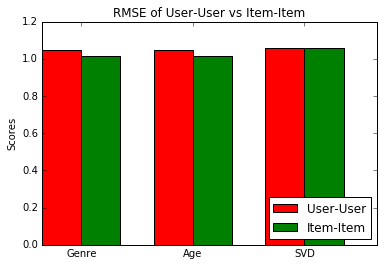

In [132]:
%matplotlib inline
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots()

rects1 = ax.bar(ind, RMSE_user, width, color='r')

rects2 = ax.bar(ind + width, RMSE_item, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('RMSE of User-User vs Item-Item')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Genre', 'Age', 'SVD'))

ax.legend((rects1[0], rects2[0]), ('User-User', 'Item-Item'), loc = 4)

### Testing Smaller Decoupled Datasets with ALS

Fixing At the moment? 

In [133]:
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

def ALS_Factor(Q, lambda_, n_factors, n_iterations):

    col = list(Q.columns.values)
    index = list(Q.index.values)
    Q = Q.as_matrix()
    W = Q != 0
    W[W == True] = 1
    W[W == False] = 0
    # To be consistent with our Q matrix
    W = W.astype(np.float64, copy=False)
    m, n = Q.shape

   
    X = 5 * np.random.rand(m, n_factors) 
    Y = 5 * np.random.rand(n_factors, n)

    weighted_errors = []
    for ii in range(n_iterations):
        for u, Wu in enumerate(W):
            X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors), np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
        for i, Wi in enumerate(W.T):
            Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors), np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
        
        weighted_errors.append(get_error(Q, X, Y, W))
        print('{}th iteration is completed'.format(ii))
        
    weighted_Q_hat = np.dot(X,Y)

    weighted_Q_hat = pd.DataFrame(weighted_Q_hat, index = index, columns=col)
    return weighted_Q_hat, weighted_errors

In [134]:
ALS_Rate_1, error = ALS_Factor(Ratings_1, .1,10,20)

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
12th iteration is completed
13th iteration is completed
14th iteration is completed
15th iteration is completed
16th iteration is completed
17th iteration is completed
18th iteration is completed
19th iteration is completed


In [135]:
ALS_Add = ratings.combine_first(ALS_Rate_1)
ALS_Add_SVD = svd_red(ALS_Add,100)

ALS_user_final = pred_fin(ALS_Add.as_matrix().T,user_sim).T
ALS_item_final = pred_fin(ALS_Add.as_matrix(),item_sim)

RMSE_user.append(mean_squared_error(ratings_matrix[np.where(ratings_matrix != 0)], ALS_user_final[np.where(ratings_matrix != 0)]))
RMSE_item.append(mean_squared_error(ratings_matrix[np.where(ratings_matrix != 0)], ALS_item_final[np.where(ratings_matrix != 0)]))

In [136]:
RMSE_user

[1.0472917561252513,
 1.0473580920769943,
 1.0601397161266157,
 1.0134989900003573]

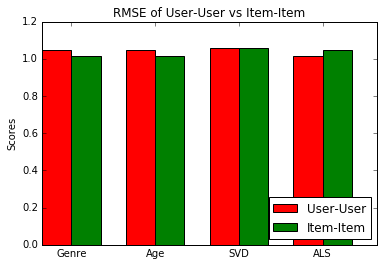

In [137]:
%matplotlib inline
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots()

rects1 = ax.bar(ind, RMSE_user, width, color='r')

rects2 = ax.bar(ind + width, RMSE_item, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('RMSE of User-User vs Item-Item')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Genre', 'Age', 'SVD', 'ALS'))

ax.legend((rects1[0], rects2[0]), ('User-User', 'Item-Item'), loc = 4)

## Evaluating the Recommendations

Now that we have all of our matrices we can determine on a smaller scale how well they all do with our "test group" For this we picked a small subset, all of the users under the age of 18. In theory, these would be the group that would obviously rate "children's" genre. So what we want here is to see if the average rating over ALL of the users produces near enough to the average of the actual rated movies. For this we picked 5 random movies, and took the average from the actual, and compared it to the averages from the various experiments tried. 

In [180]:
#Getting The Mean to add back
Rating_mean = ratings_int.mean(0,skipna=True)

W = W != 0
W[W == True] = 1
W[W == False] = 0
W = W.astype(np.float64, copy=False)

def avg_rating(ratings,movies,users,col_user,col_movies):
    Rate = ratings.add(Rating_mean, axis= 1)
    Rate = W * Rate
    Rate = subset_movies(Rate,movies,col_movies)
    Rate = subset_users(Rate,users,col_user)
    Rate = Rate.replace(0, np.nan)
    mean = Rate.mean(skipna=True,axis=0)
    std = Rate.std(skipna=True,axis=0)

    return mean, std

col = list(Q.columns.values)
index = list(Q.index.values)

ratings = pd.DataFrame(ratings, index = index, columns=col)
Total_user_final = pd.DataFrame(Total_user_final, index = index, columns=col)
Age_user_final = pd.DataFrame(Age_user_final, index = index, columns=col)
ALS_user_final = pd.DataFrame(ALS_user_final, index = index, columns=col)




### Calculating Average Values

In [182]:
mean0, std0 =avg_rating(ratings,movies,users,'age_1',"genre_Children's")

In [183]:
mean1, std1 = avg_rating(Total_user_final,movies,users,'age_1',"genre_Children's")

In [184]:
mean3, std3 =avg_rating(Age_user_final,movies,users,'age_1',"genre_Children's")

In [185]:
mean5, std5 =avg_rating(ALS_user_final,movies,users,'age_1',"genre_Children's")

In [198]:
ls = [1,56,146,3114,3287]

In [215]:
mean= mean0.loc[ls]

In [220]:
mean = pd.concat([mean0.loc[ls],mean1.loc[ls],mean3.loc[ls],mean5.loc[ls]], axis =1)

In [221]:
std = pd.concat([std0.loc[ls],std1.loc[ls],std3.loc[ls],std5.loc[ls]], axis =1)

In [251]:
plt.rcParams['figure.figsize'] = (100.0, 15.0)

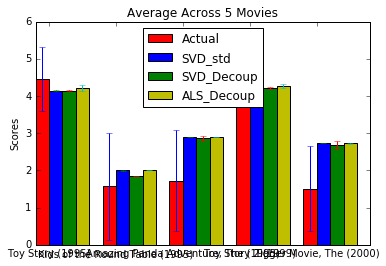

In [252]:
%matplotlib inline
#movie_titles = movie_titles.set_index("movies_id")
movie_axis = movie_titles.loc[ls]
movie_axis = list(movie_axis['title'])

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.20       # the width of the bars
fig, ax = plt.subplots()

rects1 = ax.bar(ind, list(mean[0]), width, color='r',yerr=list(std[0]))
rects2 = ax.bar(ind + width, list(mean[1]), width, color='b',yerr=list(std[1]))
rects3 = ax.bar(ind + width*2, list(mean[2]), width, color='g',yerr=list(std[2]))
rects4 = ax.bar(ind + width*3, list(mean[3]), width, color='y',yerr=list(std[3]))

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title("Average Across 5 Movies")
ax.set_xticks(ind + width)
ax.set_xticklabels(movie_axis)


ax.legend((rects1[0], rects2[0],rects3[0],rects4[0]), ('Actual', 'SVD_std', 'SVD_Decoup', 'ALS_Decoup'), loc = 9)

In [226]:
mean

,0,1,2,3
1,4.454962,4.146356,4.141204,4.212571
56,1.569965,2.001670,1.855339,1.999923
146,1.723691,2.890161,2.860527,2.885068
3114,4.759612,4.218280,4.215064,4.281136
3287,1.503855,2.727379,2.678494,2.723856


In [253]:
std

,0,1,2,3
1,0.851995,0.002707,0.019190,0.072509
56,1.435858,0.009319,0.002912,0.000000
146,1.357996,0.003565,0.058054,0.000440
3114,0.929881,0.002488,0.017781,0.054679
3287,1.142512,0.003914,0.114635,0.006362


## Results and Discussion

The above code shows that the factorization techniques utilized produce accurate results, that mimicked the actual data well on a large scale. However, what we don't see from the data is much diversity, and it's like that the factorization that we employed produced much more of a overfitting then we would like to see. As you can see from the above graph, the standard deviations across the users was very small after factorization. This is likely due to the fact that mean-centered techniques were used, and the matrix factorization produced relatively small changes overall.  

## References

[1]Nguyen, J., and Zhu, M.  Content-boosted matrix factorization techniques for recommender systems. *Statistical
Analysis and Data Mining* 2013: 6(4):286–301. https://arxiv.org/pdf/1210.5631.pdf

[2]Vozalis, M. and Margaritis K.; Applying SVD on Generalized Item-based Filtering International Journal of Computer Science & Applications 2006; Vol.3 Is.3, pp 27- 51 http://www.tmrfindia.org/ijcsa/v3i34.pdf

[3]Harper, F.M. and Konstan, J.; The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 2015: 5, 4, Article 19, 19 pages. http://dx.doi.org/10.1145/2827872 http://grouplens.org/datasets/movielens/

[4]G. Adomavicius, A. Tuzhilin, Context-Aware recommender Systems, in: F. Ricci, et al. (Ed.), Recommender Systems Handbook, 2011, pp. 217–253. http://ids.csom.umn.edu/faculty/gedas/nsfcareer/CARS-chapter-2010.pdf

[5]Barjasteh, I., Forsati, R., et al. Cold-Start Item and User Recommendation with Decoupled Completion and Transduction
https://www.cse.msu.edu/~forsati/cold-recsys2015.pdf (This is the slide, I am trying to obtain the PDF through the website)

[6] Bugra, A. Alternating Least Squares Method for Collaborative Filtering Bugra Machine Learning Newletter 2014 http://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/